In [1]:
import os 
import sys
from tqdm import tqdm
sys.path.append('..')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import torch
from torch.utils.data import DataLoader
from src.py_dataset import *
register_matplotlib_converters()

## 画出训练曲线

In [2]:
# df = pd.read_csv('../result/LSTM_result_file.csv')
# df = pd.read_csv('../result/ANN_nD.csv')
# df = pd.read_csv('../result/one_LSTM_result_file.csv')
df = pd.read_csv('../result/LSTM_1D.csv')
# df = pd.read_csv('../result/EDLSTM_nD.csv')
# df = pd.read_csv('../result/EDLSTM_1D_tf.csv')
# df = pd.read_csv('../result/STAttention.csv')

In [4]:
file_list = ['../result/STAttention.csv', '../result/EDLSTM_1D_tf.csv', 
             '../result/EDLSTM_nD.csv', '../result/LSTM_1D.csv',
             '../result/ANN_nD.csv']

In [3]:
plt.figure(facecolor='w', figsize=(12, 8))
for file in file_list:
    df = pd.read_csv(file)
    train_curve = df['train_mse_curve'].iloc[-1]
    valid_curve = df['valid_mse_curve'].iloc[-1]
    train_curve = list(map(float, train_curve[1: -1].split(',')))
    valid_curve = list(map(float, valid_curve[1: -1].split(',')))
#     plt.plot(np.log(train_curve))
    plt.plot(np.log(valid_curve))
#     plt.legend(['train', 'valid'])
plt.legend([i[10: -4] for i in file_list])
plt.xlabel('epochs')
plt.ylabel('train log(MSE) error')
plt.savefig('../result/figures/valid_loss_model_compare.png', format='png', dpi=500)
plt.show()

NameError: name 'file_list' is not defined

<Figure size 864x576 with 0 Axes>

In [8]:
train_curve = df['train_mse_curve'].iloc[-1]
valid_curve = df['valid_mse_curve'].iloc[-1]
train_curve = list(map(float, train_curve[1: -1].split(',')))
valid_curve = list(map(float, valid_curve[1: -1].split(',')))

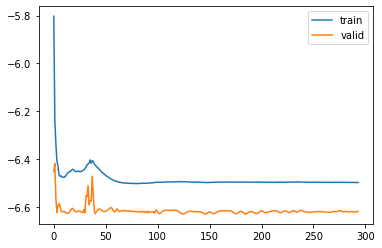

In [9]:
plt.figure(facecolor='w')
plt.plot(np.log(train_curve))
plt.plot(np.log(valid_curve))
plt.legend(['train', 'valid'])
plt.show()

## 探究模型效果

In [3]:
import sys
sys.path.append('..')
import torch
from datetime import datetime
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from src.py_dataset import *

In [4]:
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/ANN_nD.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/one_LSTM.pkl', map_location='cpu')
model = torch.load('../rnn_model/saved_pkl_model/LSTM_1D.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM_nD.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM_1D_tf.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/STAttention.pkl', map_location='cpu')
model.eval()
batch_size = 16
dataset_path = '../Dataset/3bs_8q_4p_dataset_washed.csv'
dataset = GpuResidualDataset('valid', dataset_path, 40, 4)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)
data = dataset.data
df_seasonal = dataset.df_seasonal
data_ori = dataset.data_ori

dataset prepared !


In [5]:
data.head(2)

,datetime,timestamp,q1,p1,p2,q2,q3,p3,q4,q5,...,q11,p4,p5,p6,p7,season,weekday,hour,month,weekofyear
58108,2019-01-01 01:00:00,1546275600,-0.008790,0.030047,-0.003560,-0.017574,-0.017732,-0.097984,-0.003742,0.052200,...,-0.034968,-0.030235,0.034070,0.114198,0.036935,1,1,1,1,1
58110,2019-01-01 01:30:00,1546277400,-0.002436,0.013918,0.013466,0.000977,0.004558,0.012123,0.006844,0.017967,...,0.023250,-0.010334,-0.036808,-0.026961,0.044997,1,1,1,1,1


In [6]:
model

LSTM_1D(
  (LSTM): LSTM(1, 64, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (Tanh): Tanh()
)

In [19]:
# output_list = []
# for i, (input_p, input_time, label_p, decoder_time) in enumerate(dataloader):
#     print(i, end='')
# #     print(\r, i, end='')
#     outputs_p = model(input_p, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
# #     outputs_p = model(input_p, input_time)
#     for j in range(0, batch_size):
#         output_list += [outputs_p[j, -1].detach().numpy()]
# #                     outputs_p[1, -1].detach().numpy()]
#     if i > 4200/batch_size:
#         break

# # 多步预测
# output_list = []
# output_list_30min = []
# label_list = []
# for i, (input_p_q, input_time, label_p, decoder_time) in enumerate(dataloader):
#     label_list += [label_p[:,43]]
#     for j in range(0, 4):
#         outputs_p = model(input_p_q, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
#         label_p[:, 0:39] = label_p[:,1:40]
#         label_p[:, 39] = outputs_p.squeeze(2)[:,-1]
#         if j == 0:
#             output_list_30min += [outputs_p[0, -1, :].detach().numpy()]    
#         if j == 3:
#             output_list += [outputs_p[0, -1, :].detach().numpy()]
# #     if i > 1500:
# #         break

# data['out_pressure_pred'] = 0
# data['out_pressure_pred'].iloc[:len(output_list)] = output_list
# data['out_pressure_pred'] = data['out_pressure_pred'].copy().shift(40+4)

# 多步预测，加重构
output_list = []
resid_list = []
label_list = []
for i, (input_p_q, input_time, label_p, decoder_time) in tqdm(enumerate(dataloader)):
#     print(i, end='')
    label_list += [label_p[:,43]]
    resid = np.zeros([batch_size, 1])
    for j in range(0, 4):
        outputs_p = model(input_p_q, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
        label_p[:, 0:39] = label_p[:,1:40]
        label_p[:, 39] = outputs_p.squeeze(2)[:,-1]
#         if j == 3:
    if resid.shape[0] == batch_size:
        resid += outputs_p[:, -1, :].detach().numpy()
    
        resid_list += [resid]


0it [00:00, ?it/s]
1it [00:01,  1.33s/it]
2it [00:02,  1.32s/it]
3it [00:03,  1.32s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.32s/it]
6it [00:07,  1.32s/it]
7it [00:09,  1.31s/it]
8it [00:10,  1.32s/it]
9it [00:11,  1.32s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.31s/it]
12it [00:15,  1.31s/it]
13it [00:17,  1.32s/it]
14it [00:18,  1.33s/it]
15it [00:19,  1.33s/it]
16it [00:21,  1.32s/it]
17it [00:22,  1.31s/it]
18it [00:23,  1.30s/it]
19it [00:24,  1.30s/it]
20it [00:26,  1.30s/it]
21it [00:27,  1.31s/it]
22it [00:28,  1.31s/it]
23it [00:30,  1.30s/it]
24it [00:31,  1.31s/it]
25it [00:32,  1.30s/it]
26it [00:34,  1.30s/it]
27it [00:35,  1.29s/it]
28it [00:36,  1.30s/it]
29it [00:37,  1.30s/it]
30it [00:39,  1.31s/it]
31it [00:40,  1.32s/it]
32it [00:41,  1.31s/it]
33it [00:43,  1.31s/it]
34it [00:44,  1.31s/it]
35it [00:45,  1.32s/it]
36it [00:47,  1.36s/it]
37it [00:48,  1.35s/it]
38it [00:50,  1.34s/it]
39it [00:51,  1.34s/it]
40it [00:52,  1.35s/it]
41it [00:54,  1.34s/it]
42it 

KeyboardInterrupt: 

In [20]:
len(resid_list)

272

In [8]:
resid_list = np.array(resid_list[:-1]).reshape(-1)

In [10]:
station_for_pred = 'q8'
data['resid'] = 0
data['resid'].iloc[40+4-1: 40+4-1+len(resid_list)] = resid_list
data['resid_ori'] = data[station_for_pred].copy()
data['seasonal'] = df_seasonal[station_for_pred].copy()
data['diff'] = data['resid'] + data['seasonal'].copy().rolling(4).sum()
data['2h_before'] = data_ori['q8'].copy().shift(4)
data['out_pressure_pred'] = data['diff'] + data['2h_before']
data['out_pressure_pred_noresid'] = data['2h_before'].copy() + data['seasonal'].copy().rolling(4).sum()
data['out_pressure_ori'] = data_ori['q8'].copy()
# data.head(50)

In [ ]:
# data['out_pressure_pred'] = 0
# data['out_pressure_pred'].iloc[:len(output_list)] = output_list
# data['out_pressure_pred'] = data['out_pressure_pred'].copy().shift(40+4)
# # data['datetime'] = data['datetime'].apply(str_to_datetime)

../result/figures/LSTM_1D.png


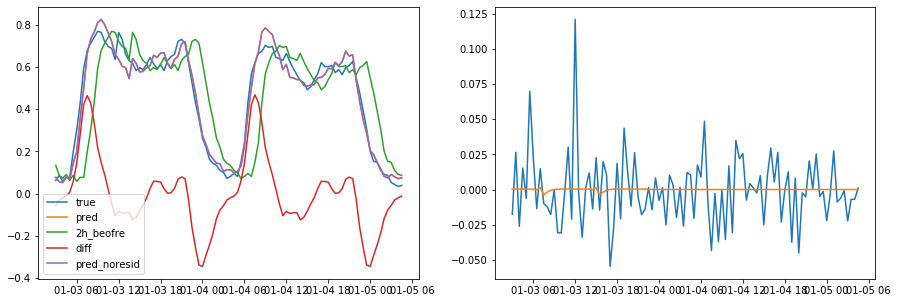

In [20]:
start = 100
length = 100
data_plot = data.iloc[start: start+length]
plt.figure(figsize=(15,5), facecolor='w')
plt.subplot(121)
plt.plot(data_plot['datetime'], data_plot['out_pressure_ori'])
plt.plot(data_plot['datetime'], data_plot['out_pressure_pred'])
plt.plot(data_plot['datetime'], data_plot['2h_before'])
plt.plot(data_plot['datetime'], data_plot['diff'])
plt.plot(data_plot['datetime'], data_plot['out_pressure_pred_noresid'])
# plt.plot(data_plot['datetime'], data_plot['diff']+data_plot['2h_before'])
# plt.xlim([datetime(2019,1,15), datetime(2019, 1, 18)])
plt.legend(['true', 'pred', '2h_beofre','diff','pred_noresid'])

plt.subplot(122)
plt.plot(data_plot['datetime'], data_plot['resid_ori'])
plt.plot(data_plot['datetime'], data_plot['resid'])
plt.plot()
fig_path = '../result/figures/' + model.model_name + '.png'
print(fig_path)
# if not os.path.exists(fig_path):
#     plt.savefig(fig_path, format='png',dpi=1000)
#     print('fig_svaed !')
# else:
#     plt.savefig(fig_path , format='png',dpi=1000)
#     print('fig_rewrited !')
plt.show()

In [26]:
from sklearn import metrics
import numpy as np
from sklearn import preprocessing
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
    metrics_dict['MSE'] = metrics.mean_squared_error(y_true, y_pred)
    metrics_dict['MAPE'] = np.mean(np.true_divide(np.abs(y_true-y_pred), y_true))
    return metrics_dict
data_eval = data.iloc[44:]
y_pred = data_eval['out_pressure_pred'].values
y_true = data_eval['out_pressure_ori'].values 
eval_dict = eval_metrics(y_true, y_pred)
print(eval_dict)

import torch
crit_mse = torch.nn.MSELoss()
crit_mae = torch.nn.L1Loss()
print(crit_mse(torch.tensor(data_eval['out_pressure_pred'].values), torch.tensor(data_eval['out_pressure_ori'].values)))
print(crit_mae(torch.tensor(data_eval['out_pressure_pred'].values), torch.tensor(data_eval['out_pressure_ori'].values)))

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


{'MAE': 0.055549835064162945, 'MSE': 0.006605702784959317, 'MAPE': inf}
tensor(0.0066, dtype=torch.float64)
tensor(0.0555, dtype=torch.float64)


每次预测四步，然后叠加：{'MAE': 0.05555471487052451, 'MSE': 0.006607739037286552, 'MAPE': inf}

不预测resid，只用seasonal {'MAE': 0.05555047750253521, 'MSE': 0.0066058812527430115, 'MAPE': inf}

## spatial attention

In [51]:
att_score = np.array([0.0164, 0.0113, 0.0131, 0.0449, 0.0701, 0.0171, 0.0236, 0.0078, 0.0054,
        0.0056, 0.0065, 0.0065, 0.0171, 0.0315, 0.1486, 0.0105, 0.0078, 0.0061])
columns = ['q'+str(i) for i in range(1,12)] + ['p'+str(i) for i in range(1,8)]

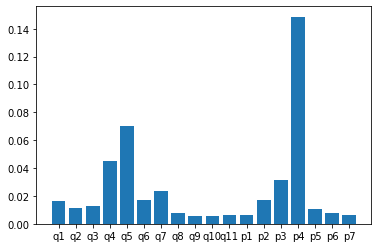

In [55]:
plt.figure(facecolor='w')
plt.bar(columns, att_score)
plt.savefig('../result/figures/spatial_attention_score.png')

## temporal attention

In [59]:
att_score = np.array([0.1488, 0.1728, 0.1884, 0.2039, 0.2198, 0.2400, 0.2644, 0.2974, 0.3336,
        0.3977, 0.3691, 0.2976, 0.2594, 0.2369, 0.2377, 0.2448, 0.2570, 0.2649,
        0.2577, 0.2458, 0.2378, 0.2258, 0.2172, 0.2142, 0.2094, 0.2200, 0.2254,
        0.2049, 0.1860, 0.1767, 0.1746, 0.1739, 0.1728, 0.1729, 0.1789, 0.1936,
        0.2109, 0.2112, 0.2061, 0.2000])
x = list(range(-40,0))

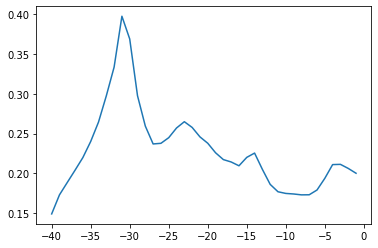

In [62]:
plt.figure(facecolor='w')
plt.plot(x, att_score)
plt.savefig('../result/figures/temporal_attention.png')